In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from linearmodels.panel import PanelOLS

# Load rice data
df_rice = pd.read_csv('/content/Cleaned_Rice_Panel_Dataset__with_Real_Yield_.csv')  # Replace with actual filename
original_rice = df_rice.copy()

# Panel index
df_rice = df_rice.set_index(['Dist_Code', 'Year'])

# Clean invalid values
df_rice = df_rice.replace([np.inf, -np.inf, '#NAME?'], np.nan)
df_rice = df_rice.dropna(subset=[
    'log_rice_yield', 'rice_temp', 'rice_precip', 'rice_irrigation', 'rice_fert'
])

# Filter out negative fertilizer values (e.g., -1 in your sample)
df_rice = df_rice[df_rice['rice_fert'] >= 0]

# Time trend
df_rice['t'] = df_rice.index.get_level_values('Year') - df_rice.index.get_level_values('Year').min()
df_rice['t_sq'] = df_rice['t'] ** 2

# Normalize explanatory variables
for var in ['rice_temp', 'rice_precip', 'rice_irrigation', 'rice_fert']:
    df_rice[f'{var}_norm'] = (df_rice[var] - df_rice[var].mean()) / df_rice[var].std()

# Track rows dropped
print(f"RICE | Original: {original_rice.shape[0]}, Cleaned: {df_rice.shape[0]}, Dropped: {original_rice.shape[0] - df_rice.shape[0]}")

# Estimate Model 1
exog_vars = ['rice_temp_norm', 'rice_precip_norm', 'rice_irrigation_norm', 'rice_fert_norm', 't', 't_sq']
exog = sm.add_constant(df_rice[exog_vars])
model = PanelOLS(df_rice['log_rice_yield'], exog, entity_effects=True)
results = model.fit(cov_type='clustered', cluster_entity=True)

print("\n📘 RICE MODEL SUMMARY")
print(results.summary)


RICE | Original: 3969, Cleaned: 3656, Dropped: 313

📘 RICE MODEL SUMMARY
                          PanelOLS Estimation Summary                           
Dep. Variable:         log_rice_yield   R-squared:                        0.2309
Estimator:                   PanelOLS   R-squared (Between):              0.0722
No. Observations:                3656   R-squared (Within):               0.2309
Date:                Sun, Jul 13 2025   R-squared (Overall):              0.1058
Time:                        11:47:00   Log-likelihood                   -566.58
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      175.28
Entities:                         148   P-value                           0.0000
Avg Obs:                       24.703   Distribution:                  F(6,3502)
Min Obs:                       8.0000                                           
Max Obs:                       26.00

rice with ma and quadratuc

In [ ]:
# Install if not done already
!pip install linearmodels

# Import libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
from linearmodels.panel import PanelOLS

# Load data
df = pd.read_csv('/content/Cleaned_Rice_Panel_Dataset__with_Real_Yield_.csv')  # Replace with your actual filename
original_df = df.copy()

# Set index
df = df.set_index(['Dist_Code', 'Year'])
df = df.sort_index()

# Replace invalid values
df = df.replace([np.inf, -np.inf, '#NAME?'], np.nan)

# Drop invalid or missing values
df = df.dropna(subset=[
    'log_rice_yield', 'rice_temp', 'rice_precip', 'rice_irrigation', 'rice_fert'
])

# Fix negative fertilizer values if any (e.g., -1 in your sample)
df = df[df['rice_fert'] >= 0]

# Apply 2-year moving average within districts
for var in ['rice_temp', 'rice_precip', 'rice_irrigation', 'rice_fert']:
    df[f'{var}_ma'] = df.groupby('Dist_Code')[var].transform(lambda x: x.rolling(2, min_periods=1).mean())

# Drop rows with missing MA values
df = df.dropna(subset=[
    'rice_temp_ma', 'rice_precip_ma', 'rice_irrigation_ma', 'rice_fert_ma'
])

# Time trend
df['t'] = df.index.get_level_values('Year') - df.index.get_level_values('Year').min()
df['t_sq'] = df['t'] ** 2

# Normalize MA variables
for var in ['rice_temp_ma', 'rice_precip_ma', 'rice_irrigation_ma', 'rice_fert_ma']:
    df[f'{var}_norm'] = (df[var] - df[var].mean()) / df[var].std()

# Quadratic terms
df['temp_sq'] = df['rice_temp_ma_norm'] ** 2
df['precip_sq'] = df['rice_precip_ma_norm'] ** 2

# Define regressors
exog_vars = [
    'rice_temp_ma_norm', 'temp_sq',
    'rice_precip_ma_norm', 'precip_sq',
    'rice_irrigation_ma_norm', 'rice_fert_ma_norm',
    't', 't_sq'
]
exog = sm.add_constant(df[exog_vars])

# Estimate fixed effects model
model = PanelOLS(df['log_rice_yield'], exog, entity_effects=True)
results = model.fit(cov_type='clustered', cluster_entity=True)

# Report
original_len = original_df.shape[0]
final_len = df.shape[0]
print(f"\n✅ Rice Model with Moving Averages & Quadratic Terms")
print(f"Original rows: {original_len}, After cleaning: {final_len}, Dropped: {original_len - final_len}")
print(results.summary)



✅ Rice Model with Moving Averages & Quadratic Terms
Original rows: 3969, After cleaning: 3656, Dropped: 313
                          PanelOLS Estimation Summary                           
Dep. Variable:         log_rice_yield   R-squared:                        0.2020
Estimator:                   PanelOLS   R-squared (Between):              0.0094
No. Observations:                3656   R-squared (Within):               0.2020
Date:                Sun, Jul 13 2025   R-squared (Overall):              0.0501
Time:                        12:33:19   Log-likelihood                   -634.16
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      110.74
Entities:                         148   P-value                           0.0000
Avg Obs:                       24.703   Distribution:                  F(8,3500)
Min Obs:                       8.0000                                           


anaylsis for wheat

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from linearmodels.panel import PanelOLS

# Load data
df = pd.read_csv('/content/Filtered_Wheat_Panel_Dataset___10_Years_.csv')  # Replace with actual file name

# Set multi-index: (district, year)
df = df.set_index(['Dist_Code', 'Year'])

# Create time trend and its square
df['t'] = df.index.get_level_values('Year') - df.index.get_level_values('Year').min()
df['t_sq'] = df['t'] ** 2

# Drop rows with missing values in required columns
df = df.dropna(subset=[
    'log_wheat_yield', 'wheat_temp', 'wheat_precip',
    'wheat_irrigation', 'wheat_fert'
])


# Define regressors for Model 1
exog_vars = ['wheat_temp', 'wheat_precip', 'wheat_irrigation', 'wheat_fert', 't', 't_sq']
exog = sm.add_constant(df[exog_vars])

# Estimate Model 1 with district fixed effects
model1 = PanelOLS(df['log_wheat_yield'], exog, entity_effects=True)
results1 = model1.fit(cov_type='clustered', cluster_entity=True)

print("Model 1: Linear Weather Function")
print(results1.summary)


/usr/local/lib/python3.11/dist-packages/linearmodels/panel/model.py:1677: RuntimeWarning: invalid value encountered in add
  y_arr = y_arr + y_gm


ValueError: array must not contain infs or NaNs

Dist_Code	Year	State_Name	Dist_Name	log_wheat_yield	wheat_temp	wheat_precip	wheat_irrigation	wheat_fert


In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from linearmodels.panel import PanelOLS

# Load the wheat data
df = pd.read_csv('/content/Filtered_Wheat_Panel_Dataset___10_Years_.csv')  # update with actual file path

# Set panel index
df = df.set_index(['Dist_Code', 'Year'])

# Create time trend
df['t'] = df.index.get_level_values('Year') - df.index.get_level_values('Year').min()
df['t_sq'] = df['t'] ** 2

# Drop missing or invalid rows
df = df.dropna(subset=['log_wheat_yield', 'wheat_temp', 'wheat_precip', 'wheat_irrigation', 'wheat_fert'])


In [ ]:
# Normalize explanatory variables
for col in ['wheat_temp', 'wheat_precip', 'wheat_irrigation', 'wheat_fert']:
    df[f'{col}_norm'] = (df[col] - df[col].mean()) / df[col].std()

# Define regressors
exog_vars = ['wheat_temp_norm', 'wheat_precip_norm', 'wheat_irrigation_norm', 'wheat_fert_norm', 't', 't_sq']
exog = sm.add_constant(df[exog_vars])

# Estimate model
model1 = PanelOLS(df['log_wheat_yield'], exog, entity_effects=True)
results1 = model1.fit(cov_type='clustered', cluster_entity=True)

print("📘 Model 1: Linear Weather Function (Wheat)")
print(results1.summary)


/usr/local/lib/python3.11/dist-packages/linearmodels/panel/model.py:1677: RuntimeWarning: invalid value encountered in add
  y_arr = y_arr + y_gm


ValueError: array must not contain infs or NaNs

In [ ]:
# Save the cleaned and modified DataFrame to a new CSV
df.to_csv('cleaned_wheat_data.csv')


In [ ]:
from google.colab import files
files.download('cleaned_wheat_data.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Reconfirm numeric columns have no infinite values
cols_to_check = [
    'log_wheat_yield', 'wheat_temp', 'wheat_precip',
    'wheat_irrigation', 'wheat_fert'
]

# Remove inf/-inf and NaNs
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=cols_to_check)

# Normalize after cleaning
for col in ['wheat_temp', 'wheat_precip', 'wheat_irrigation', 'wheat_fert']:
    df[f'{col}_norm'] = (df[col] - df[col].mean()) / df[col].std()

# Create time trend (if not already present)
df['t'] = df.index.get_level_values('Year') - df.index.get_level_values('Year').min()
df['t_sq'] = df['t'] ** 2


In [ ]:
exog_vars = ['wheat_temp_norm', 'wheat_precip_norm', 'wheat_irrigation_norm', 'wheat_fert_norm', 't', 't_sq']
exog = sm.add_constant(df[exog_vars])

model1 = PanelOLS(df['log_wheat_yield'], exog, entity_effects=True)
results1 = model1.fit(cov_type='clustered', cluster_entity=True)

print("📘 Model 1: Linear Weather Function (Wheat)")
print(results1.summary)


📘 Model 1: Linear Weather Function (Wheat)
                          PanelOLS Estimation Summary                           
Dep. Variable:        log_wheat_yield   R-squared:                        0.3954
Estimator:                   PanelOLS   R-squared (Between):              0.3807
No. Observations:                4673   R-squared (Within):               0.3954
Date:                Sun, Jul 13 2025   R-squared (Overall):              0.3727
Time:                        08:53:26   Log-likelihood                    397.22
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      493.31
Entities:                         142   P-value                           0.0000
Avg Obs:                       32.908   Distribution:                  F(6,4525)
Min Obs:                       2.0000                                           
Max Obs:                       34.000   F-statistic (robust):     

In [ ]:
print(df[exog_vars + ['log_wheat_yield']].isna().sum())   # should all be 0


wheat_temp_norm          0
wheat_precip_norm        0
wheat_irrigation_norm    0
wheat_fert_norm          0
t                        0
t_sq                     0
log_wheat_yield          0
dtype: int64


to check how many were dropped

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from linearmodels.panel import PanelOLS

# Step 1: Load the dataset
df = pd.read_csv('/content/Filtered_Wheat_Panel_Dataset___10_Years_.csv')  # Replace with actual path/filename
original_df = df.copy()  # Save original before modifying

# Step 2: Set panel index for fixed effects model
df = df.set_index(['Dist_Code', 'Year'])

# Step 3: Clean the data
# Replace infinite values with NaN
df = df.replace([np.inf, -np.inf], np.nan)

# Drop rows with missing values in required columns
required_cols = ['log_wheat_yield', 'wheat_temp', 'wheat_precip', 'wheat_irrigation', 'wheat_fert']
df = df.dropna(subset=required_cols)

# Step 4: Create time trend and its square
df['t'] = df.index.get_level_values('Year') - df.index.get_level_values('Year').min()
df['t_sq'] = df['t'] ** 2

# Step 5: Normalize (standardize) weather & input variables
for col in ['wheat_temp', 'wheat_precip', 'wheat_irrigation', 'wheat_fert']:
    df[f'{col}_norm'] = (df[col] - df[col].mean()) / df[col].std()

# Step 6: Report how many rows were dropped
original_len = original_df.shape[0]
cleaned_len = df.shape[0]
print(f"Original rows: {original_len}, After cleaning: {cleaned_len}, Dropped: {original_len - cleaned_len}")

# Step 7: Define explanatory variables for Model 1 (Linear)
exog_vars = [
    'wheat_temp_norm', 'wheat_precip_norm',
    'wheat_irrigation_norm', 'wheat_fert_norm',
    't', 't_sq'
]
exog = sm.add_constant(df[exog_vars])

# Step 8: Estimate Model 1 using fixed effects (district level)
model1 = PanelOLS(df['log_wheat_yield'], exog, entity_effects=True)
results1 = model1.fit(cov_type='clustered', cluster_entity=True)

# Step 9: Display Model 1 Results
print("\n📘 Model 1: Linear Weather Function (Wheat)")
print(results1.summary)


Original rows: 4688, After cleaning: 4673, Dropped: 15

📘 Model 1: Linear Weather Function (Wheat)
                          PanelOLS Estimation Summary                           
Dep. Variable:        log_wheat_yield   R-squared:                        0.3954
Estimator:                   PanelOLS   R-squared (Between):              0.3807
No. Observations:                4673   R-squared (Within):               0.3954
Date:                Sun, Jul 13 2025   R-squared (Overall):              0.3727
Time:                        09:11:16   Log-likelihood                    397.22
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      493.31
Entities:                         142   P-value                           0.0000
Avg Obs:                       32.908   Distribution:                  F(6,4525)
Min Obs:                       2.0000                                           
Max Obs:  

without fertilizer variable

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from linearmodels.panel import PanelOLS

# Step 1: Load the dataset
df = pd.read_csv('/content/Filtered_Wheat_Panel_Dataset___10_Years_.csv')  # Replace with actual path/filename
original_df = df.copy()  # Save original before modifying

# Step 2: Set panel index for fixed effects model
df = df.set_index(['Dist_Code', 'Year'])

# Step 3: Clean the data
# Replace infinite values with NaN
df = df.replace([np.inf, -np.inf], np.nan)

# Drop rows with missing values in required columns
required_cols = ['log_wheat_yield', 'wheat_temp', 'wheat_precip', 'wheat_irrigation', 'wheat_fert']
df = df.dropna(subset=required_cols)

# Step 4: Create time trend and its square
df['t'] = df.index.get_level_values('Year') - df.index.get_level_values('Year').min()
df['t_sq'] = df['t'] ** 2

# Step 5: Normalize (standardize) weather & input variables
for col in ['wheat_temp', 'wheat_precip', 'wheat_irrigation']:
    df[f'{col}_norm'] = (df[col] - df[col].mean()) / df[col].std()

# Step 6: Report how many rows were dropped
original_len = original_df.shape[0]
cleaned_len = df.shape[0]
print(f"Original rows: {original_len}, After cleaning: {cleaned_len}, Dropped: {original_len - cleaned_len}")

# Step 7: Define explanatory variables for Model 1 (Linear)
exog_vars = [
    'wheat_temp_norm', 'wheat_precip_norm',
    'wheat_irrigation_norm',
    't', 't_sq'
]
exog = sm.add_constant(df[exog_vars])

# Step 8: Estimate Model 1 using fixed effects (district level)
model1 = PanelOLS(df['log_wheat_yield'], exog, entity_effects=True)
results1 = model1.fit(cov_type='clustered', cluster_entity=True)

# Step 9: Display Model 1 Results
print("\n📘 Model 1: Linear Weather Function (Wheat)")
print(results1.summary)


Original rows: 4688, After cleaning: 4673, Dropped: 15

📘 Model 1: Linear Weather Function (Wheat)
                          PanelOLS Estimation Summary                           
Dep. Variable:        log_wheat_yield   R-squared:                        0.3952
Estimator:                   PanelOLS   R-squared (Between):              0.3800
No. Observations:                4673   R-squared (Within):               0.3952
Date:                Sun, Jul 13 2025   R-squared (Overall):              0.3727
Time:                        09:20:15   Log-likelihood                    396.11
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      591.39
Entities:                         142   P-value                           0.0000
Avg Obs:                       32.908   Distribution:                  F(5,4526)
Min Obs:                       2.0000                                           
Max Obs:  

sugarcane


In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from linearmodels.panel import PanelOLS

# Load sugarcane data
df_sugar = pd.read_csv('/content/Filtered_Sugarcane_Panel_Dataset___10_Years_.csv')
original_sugar = df_sugar.copy()

# Panel index
df_sugar = df_sugar.set_index(['Dist_Code', 'Year'])

# Clean invalid values
df_sugar = df_sugar.replace([np.inf, -np.inf, '#NAME?'], np.nan)
df_sugar = df_sugar.dropna(subset=[
    'log_sugarcane_yield', 'sugarcane_temp', 'sugarcane_precip', 'sugarcane_irrigation', 'sugarcane_fert'
])

# Time trend
df_sugar['t'] = df_sugar.index.get_level_values('Year') - df_sugar.index.get_level_values('Year').min()
df_sugar['t_sq'] = df_sugar['t'] ** 2

# Normalize explanatory variables
for var in ['sugarcane_temp', 'sugarcane_precip', 'sugarcane_irrigation', 'sugarcane_fert']:
    df_sugar[f'{var}_norm'] = (df_sugar[var] - df_sugar[var].mean()) / df_sugar[var].std()

# Track rows dropped
print(f"SUGARCANE | Original: {original_sugar.shape[0]}, Cleaned: {df_sugar.shape[0]}, Dropped: {original_sugar.shape[0] - df_sugar.shape[0]}")

# Estimate Model 1
exog_vars = ['sugarcane_temp_norm', 'sugarcane_precip_norm', 'sugarcane_irrigation_norm', 'sugarcane_fert_norm', 't', 't_sq']
exog = sm.add_constant(df_sugar[exog_vars])
model = PanelOLS(df_sugar['log_sugarcane_yield'], exog, entity_effects=True)
results = model.fit(cov_type='clustered', cluster_entity=True)

print("\n📘 SUGARCANE MODEL SUMMARY")
print(results.summary)


SUGARCANE | Original: 4758, Cleaned: 4748, Dropped: 10

📘 SUGARCANE MODEL SUMMARY
                           PanelOLS Estimation Summary                           
Dep. Variable:     log_sugarcane_yield   R-squared:                        0.0215
Estimator:                    PanelOLS   R-squared (Between):              0.1368
No. Observations:                 4748   R-squared (Within):               0.0215
Date:                 Sun, Jul 13 2025   R-squared (Overall):              0.1108
Time:                         10:19:32   Log-likelihood                   -755.23
Cov. Estimator:              Clustered                                           
                                         F-statistic:                      16.817
Entities:                          150   P-value                           0.0000
Avg Obs:                        31.653   Distribution:                  F(6,4592)
Min Obs:                       10.0000                                           
Max Obs:        

In [ ]:
df_sugar[['sugarcane_temp', 'sugarcane_precip', 'sugarcane_irrigation', 'sugarcane_fert']].describe()


,sugarcane_temp,sugarcane_precip,sugarcane_irrigation,sugarcane_fert
count,4748.000000,4748.000000,4748.000000,4748.000000
mean,15.832841,0.407826,19.201082,1.075573
std,1.768845,0.468010,40.686474,14.039932
min,7.156000,0.000000,-1.000000,-0.050761
25%,15.121500,0.120214,0.360000,0.000492
50%,16.149875,0.276000,3.540000,0.008542
75%,17.020500,0.523250,18.810750,0.088582
max,19.432000,6.005333,282.340000,446.875000


<Axes: title={'center': 'Avg Sugarcane Yield Over Time'}, xlabel='Year'>

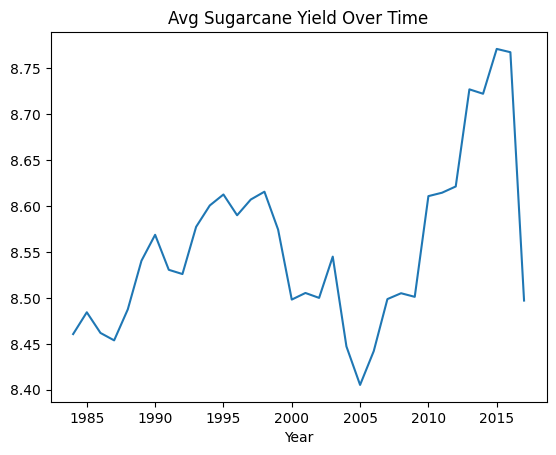

In [ ]:
df_sugar.groupby('Year')['log_sugarcane_yield'].mean().plot(title="Avg Sugarcane Yield Over Time")


cotton


with some edits to improve r squared


In [ ]:
# Step 1: Install linearmodels if not already installed
# Run this only once
!pip install linearmodels

# Step 2: Import libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
from linearmodels.panel import PanelOLS

# Step 3: Load sugarcane dataset
df = pd.read_csv('/content/Filtered_Sugarcane_Panel_Dataset___10_Years_.csv')  # Replace with your actual file path
original_df = df.copy()

# Step 4: Set panel index
df = df.set_index(['Dist_Code', 'Year'])
df = df.sort_index()  # Required for rolling averages

# Step 5: Drop missing or non-numeric entries
df = df.replace([np.inf, -np.inf, '#NAME?'], np.nan)
df = df.dropna(subset=[
    'log_sugarcane_yield', 'sugarcane_temp', 'sugarcane_precip',
    'sugarcane_irrigation', 'sugarcane_fert'
])

# Step 6: Apply 2-year moving averages (grouped by district)
for var in ['sugarcane_temp', 'sugarcane_precip', 'sugarcane_irrigation', 'sugarcane_fert']:
    df[f'{var}_ma'] = df.groupby('Dist_Code')[var].transform(lambda x: x.rolling(window=2, min_periods=1).mean())

# Step 7: Drop any remaining missing values
df = df.dropna(subset=[
    'sugarcane_temp_ma', 'sugarcane_precip_ma',
    'sugarcane_irrigation_ma', 'sugarcane_fert_ma'
])

# Step 8: Create time trend variables
df['t'] = df.index.get_level_values('Year') - df.index.get_level_values('Year').min()
df['t_sq'] = df['t'] ** 2

# Step 9: Normalize variables
for var in ['sugarcane_temp_ma', 'sugarcane_precip_ma', 'sugarcane_irrigation_ma', 'sugarcane_fert_ma']:
    df[f'{var}_norm'] = (df[var] - df[var].mean()) / df[var].std()

# Step 10: Add quadratic terms
df['temp_sq'] = df['sugarcane_temp_ma_norm'] ** 2
df['precip_sq'] = df['sugarcane_precip_ma_norm'] ** 2

# Step 11: Define explanatory variables
exog_vars = [
    'sugarcane_temp_ma_norm', 'temp_sq',
    'sugarcane_precip_ma_norm', 'precip_sq',
    'sugarcane_irrigation_ma_norm', 'sugarcane_fert_ma_norm',
    't', 't_sq'
]
exog = sm.add_constant(df[exog_vars])

# Step 12: Run PanelOLS fixed effects regression
model = PanelOLS(df['log_sugarcane_yield'], exog, entity_effects=True)
results = model.fit(cov_type='clustered', cluster_entity=True)

# Step 13: Print result summary and data stats
original_len = original_df.shape[0]
final_len = df.shape[0]
print(f"\n✅ Sugarcane Model with Moving Averages & Quadratic Terms")
print(f"Original rows: {original_len}, After cleaning: {final_len}, Dropped: {original_len - final_len}")
print(results.summary)



✅ Sugarcane Model with Moving Averages & Quadratic Terms
Original rows: 4758, After cleaning: 4748, Dropped: 10
                           PanelOLS Estimation Summary                           
Dep. Variable:     log_sugarcane_yield   R-squared:                        0.0250
Estimator:                    PanelOLS   R-squared (Between):              0.1293
No. Observations:                 4748   R-squared (Within):               0.0250
Date:                 Sun, Jul 13 2025   R-squared (Overall):              0.1069
Time:                         11:21:33   Log-likelihood                   -746.70
Cov. Estimator:              Clustered                                           
                                         F-statistic:                      14.717
Entities:                          150   P-value                           0.0000
Avg Obs:                        31.653   Distribution:                  F(8,4590)
Min Obs:                       10.0000                             

In [ ]:
# Load cotton data
df_cotton = pd.read_csv('/content/Filtered_Cotton_Panel_Dataset___10_Years_.csv')
original_cotton = df_cotton.copy()

# Panel index
df_cotton = df_cotton.set_index(['Dist_Code', 'Year'])

# Clean invalid values
df_cotton = df_cotton.replace([np.inf, -np.inf, '#NAME?'], np.nan)
df_cotton = df_cotton.dropna(subset=[
    'log_cotton_yield', 'cotton_temp', 'cotton_precip', 'cotton_irrigation', 'cotton_fert'
])

# Time trend
df_cotton['t'] = df_cotton.index.get_level_values('Year') - df_cotton.index.get_level_values('Year').min()
df_cotton['t_sq'] = df_cotton['t'] ** 2

# Normalize explanatory variables
for var in ['cotton_temp', 'cotton_precip', 'cotton_irrigation', 'cotton_fert']:
    df_cotton[f'{var}_norm'] = (df_cotton[var] - df_cotton[var].mean()) / df_cotton[var].std()

# Track rows dropped
print(f"COTTON | Original: {original_cotton.shape[0]}, Cleaned: {df_cotton.shape[0]}, Dropped: {original_cotton.shape[0] - df_cotton.shape[0]}")

# Estimate Model 1
exog_vars = ['cotton_temp_norm', 'cotton_precip_norm', 'cotton_irrigation_norm', 'cotton_fert_norm', 't', 't_sq']
exog = sm.add_constant(df_cotton[exog_vars])
model = PanelOLS(df_cotton['log_cotton_yield'], exog, entity_effects=True)
results = model.fit(cov_type='clustered', cluster_entity=True)

print("\n📘 COTTON MODEL SUMMARY")
print(results.summary)


COTTON | Original: 3247, Cleaned: 3098, Dropped: 149

📘 COTTON MODEL SUMMARY
                          PanelOLS Estimation Summary                           
Dep. Variable:       log_cotton_yield   R-squared:                        0.1101
Estimator:                   PanelOLS   R-squared (Between):             -1.7263
No. Observations:                3098   R-squared (Within):               0.1101
Date:                Sun, Jul 13 2025   R-squared (Overall):              0.0562
Time:                        10:24:26   Log-likelihood                   -2454.8
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      61.599
Entities:                         105   P-value                           0.0000
Avg Obs:                       29.505   Distribution:                  F(6,2987)
Min Obs:                       1.0000                                           
Max Obs:                       3

cotton with fert

In [ ]:
# Load cotton data
df_cotton = pd.read_csv('/content/Filtered_Cotton_Panel_Dataset___10_Years_.csv')
original_cotton = df_cotton.copy()

# Panel index
df_cotton = df_cotton.set_index(['Dist_Code', 'Year'])

# Clean invalid values
df_cotton = df_cotton.replace([np.inf, -np.inf, '#NAME?'], np.nan)
df_cotton = df_cotton.dropna(subset=[
    'log_cotton_yield', 'cotton_temp', 'cotton_precip', 'cotton_irrigation'
])

# Time trend
df_cotton['t'] = df_cotton.index.get_level_values('Year') - df_cotton.index.get_level_values('Year').min()
df_cotton['t_sq'] = df_cotton['t'] ** 2

# Normalize explanatory variables
for var in ['cotton_temp', 'cotton_precip', 'cotton_irrigation']:
    df_cotton[f'{var}_norm'] = (df_cotton[var] - df_cotton[var].mean()) / df_cotton[var].std()

# Track rows dropped
print(f"COTTON | Original: {original_cotton.shape[0]}, Cleaned: {df_cotton.shape[0]}, Dropped: {original_cotton.shape[0] - df_cotton.shape[0]}")

# Estimate Model 1
exog_vars = ['cotton_temp_norm', 'cotton_precip_norm', 'cotton_irrigation_norm', 't', 't_sq']
exog = sm.add_constant(df_cotton[exog_vars])
model = PanelOLS(df_cotton['log_cotton_yield'], exog, entity_effects=True)
results = model.fit(cov_type='clustered', cluster_entity=True)

print("\n📘 COTTON MODEL SUMMARY")
print(results.summary)


COTTON | Original: 3247, Cleaned: 3098, Dropped: 149

📘 COTTON MODEL SUMMARY
                          PanelOLS Estimation Summary                           
Dep. Variable:       log_cotton_yield   R-squared:                        0.1047
Estimator:                   PanelOLS   R-squared (Between):              0.0108
No. Observations:                3098   R-squared (Within):               0.1047
Date:                Sun, Jul 13 2025   R-squared (Overall):              0.0726
Time:                        11:27:12   Log-likelihood                   -2464.2
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      69.906
Entities:                         105   P-value                           0.0000
Avg Obs:                       29.505   Distribution:                  F(5,2988)
Min Obs:                       1.0000                                           
Max Obs:                       3

groundnut

In [ ]:
# Load groundnut data
df_ground = pd.read_csv('/content/Filtered_Groundnut_Panel_Dataset___10_Years_.csv')
original_ground = df_ground.copy()

# Panel index
df_ground = df_ground.set_index(['Dist_Code', 'Year'])

# Clean invalid values
df_ground = df_ground.replace([np.inf, -np.inf, '#NAME?'], np.nan)
df_ground = df_ground.dropna(subset=[
    'log_groundnut_yield', 'groundnut_temp', 'groundnut_precip', 'groundnut_irrigation', 'groundnut_fert'
])

# Time trend
df_ground['t'] = df_ground.index.get_level_values('Year') - df_ground.index.get_level_values('Year').min()
df_ground['t_sq'] = df_ground['t'] ** 2

# Normalize explanatory variables
for var in ['groundnut_temp', 'groundnut_precip', 'groundnut_irrigation', 'groundnut_fert']:
    df_ground[f'{var}_norm'] = (df_ground[var] - df_ground[var].mean()) / df_ground[var].std()

# Track rows dropped
print(f"GROUNDNUT | Original: {original_ground.shape[0]}, Cleaned: {df_ground.shape[0]}, Dropped: {original_ground.shape[0] - df_ground.shape[0]}")

# Estimate Model 1
exog_vars = ['groundnut_temp_norm', 'groundnut_precip_norm', 'groundnut_irrigation_norm', 'groundnut_fert_norm', 't', 't_sq']
exog = sm.add_constant(df_ground[exog_vars])
model = PanelOLS(df_ground['log_groundnut_yield'], exog, entity_effects=True)
results = model.fit(cov_type='clustered', cluster_entity=True)

print("\n📘 GROUNDNUT MODEL SUMMARY")
print(results.summary)


GROUNDNUT | Original: 4657, Cleaned: 4614, Dropped: 43

📘 GROUNDNUT MODEL SUMMARY
                           PanelOLS Estimation Summary                           
Dep. Variable:     log_groundnut_yield   R-squared:                        0.1936
Estimator:                    PanelOLS   R-squared (Between):             -0.0822
No. Observations:                 4614   R-squared (Within):               0.1936
Date:                 Sun, Jul 13 2025   R-squared (Overall):              0.1200
Time:                         10:25:30   Log-likelihood                   -2242.2
Cov. Estimator:              Clustered                                           
                                         F-statistic:                      178.57
Entities:                          145   P-value                           0.0000
Avg Obs:                        31.821   Distribution:                  F(6,4463)
Min Obs:                        9.0000                                           
Max Obs:        

for model 2 for all crops

In [ ]:
# 📦 Install required package (only once)
!pip install linearmodels

# 📚 Import libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
from linearmodels.panel import PanelOLS

# 🔗 Paste file paths here (uploaded in Colab)
file_paths = {
    'wheat': '/content/Filtered_Wheat_Panel_Dataset___10_Years_.csv',         # replace with actual path if different
    'rice': '/content/Cleaned_Rice_Panel_Dataset__with_Real_Yield_.csv',
    'sugarcane': '/content/Filtered_Sugarcane_Panel_Dataset___10_Years_.csv',
    'cotton': '/content/Filtered_Cotton_Panel_Dataset___10_Years_.csv',
    'groundnut': '/content/Filtered_Groundnut_Panel_Dataset___10_Years_.csv'
}

# 🧠 Model 2 Function (Quadratic Weather Function)
def run_model_2(file_path, crop_prefix, yield_var):
    df = pd.read_csv(file_path)
    original_df = df.copy()

    df = df.set_index(['Dist_Code', 'Year'])
    df = df.replace([np.inf, -np.inf, '#NAME?'], np.nan)

    # Drop missing rows
    vars_needed = [yield_var,
                   f'{crop_prefix}_temp',
                   f'{crop_prefix}_precip',
                   f'{crop_prefix}_irrigation',
                   f'{crop_prefix}_fert']
    df = df.dropna(subset=vars_needed)

    # Remove invalid fertilizer values (e.g. -1)
    if crop_prefix == 'rice':
        df = df[df['rice_fert'] >= 0]

    # Time trend
    df['t'] = df.index.get_level_values('Year') - df.index.get_level_values('Year').min()
    df['t_sq'] = df['t'] ** 2

    # Normalize variables
    for var in ['temp', 'precip', 'irrigation', 'fert']:
        col = f'{crop_prefix}_{var}'
        df[f'{col}_norm'] = (df[col] - df[col].mean()) / df[col].std()

    # Quadratic terms
    for var in ['temp', 'precip', 'irrigation', 'fert']:
        col = f'{crop_prefix}_{var}_norm'
        df[f'{col}_sq'] = df[col] ** 2

    # Define regressors
    exog_vars = [
        f'{crop_prefix}_temp_norm', f'{crop_prefix}_temp_norm_sq',
        f'{crop_prefix}_precip_norm', f'{crop_prefix}_precip_norm_sq',
        f'{crop_prefix}_irrigation_norm', f'{crop_prefix}_irrigation_norm_sq',
        f'{crop_prefix}_fert_norm', f'{crop_prefix}_fert_norm_sq',
        't', 't_sq'
    ]
    exog = sm.add_constant(df[exog_vars])

    # Estimate model
    model = PanelOLS(df[yield_var], exog, entity_effects=True)
    results = model.fit(cov_type='clustered', cluster_entity=True)

    # Output
    print(f"\n📗 Model 2: {crop_prefix.upper()} (Quadratic Weather Function)")
    print(f"Original rows: {original_df.shape[0]}, Cleaned: {df.shape[0]}, Dropped: {original_df.shape[0] - df.shape[0]}")
    print(results.summary)

# 📂 Run Model 2 for all crops
run_model_2(file_paths['wheat'], 'wheat', 'log_wheat_yield')
run_model_2(file_paths['rice'], 'rice', 'log_rice_yield')
run_model_2(file_paths['sugarcane'], 'sugarcane', 'log_sugarcane_yield')
run_model_2(file_paths['cotton'], 'cotton', 'log_cotton_yield')
run_model_2(file_paths['groundnut'], 'groundnut', 'log_groundnut_yield')



📗 Model 2: WHEAT (Quadratic Weather Function)
Original rows: 4688, Cleaned: 4673, Dropped: 15
                          PanelOLS Estimation Summary                           
Dep. Variable:        log_wheat_yield   R-squared:                        0.4040
Estimator:                   PanelOLS   R-squared (Between):              0.4233
No. Observations:                4673   R-squared (Within):               0.4040
Date:                Sun, Jul 13 2025   R-squared (Overall):              0.4033
Time:                        12:46:43   Log-likelihood                    430.50
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      306.45
Entities:                         142   P-value                           0.0000
Avg Obs:                       32.908   Distribution:                 F(10,4521)
Min Obs:                       2.0000                                           
Max Obs:      

graphs


linear models

In [ ]:
# 📦 Install required package (only once in Colab)
!pip install linearmodels

# 📚 Import libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
from linearmodels.panel import PanelOLS

# 🔗 Paste or modify file names here
ffile_paths = {
    'wheat': '/content/Filtered_Wheat_Panel_Dataset___10_Years_.csv',         # replace with actual path if different
    'rice': '/content/Cleaned_Rice_Panel_Dataset__with_Real_Yield_.csv',
    'sugarcane': '/content/Filtered_Sugarcane_Panel_Dataset___10_Years_.csv',
    'cotton': '/content/Filtered_Cotton_Panel_Dataset___10_Years_.csv',
    'groundnut': '/content/Filtered_Groundnut_Panel_Dataset___10_Years_.csv'
}

# 🧠 Model 1: Linear Weather Function
def run_model_1(file_path, crop_prefix, yield_var):
    df = pd.read_csv(file_path)
    original_df = df.copy()

    df = df.set_index(['Dist_Code', 'Year'])
    df = df.replace([np.inf, -np.inf, '#NAME?'], np.nan)

    # Drop rows with missing values
    needed = [yield_var,
              f'{crop_prefix}_temp',
              f'{crop_prefix}_precip',
              f'{crop_prefix}_irrigation',
              f'{crop_prefix}_fert']
    df = df.dropna(subset=needed)

    # Remove invalid fertilizer values (for rice)
    if crop_prefix == 'rice':
        df = df[df['rice_fert'] >= 0]

    # Time variables
    df['t'] = df.index.get_level_values('Year') - df.index.get_level_values('Year').min()
    df['t_sq'] = df['t'] ** 2

    # Normalize variables
    for var in ['temp', 'precip', 'irrigation', 'fert']:
        v = f'{crop_prefix}_{var}'
        df[f'{v}_norm'] = (df[v] - df[v].mean()) / df[v].std()

    # Define regressors
    exog_vars = [
        f'{crop_prefix}_temp_norm',
        f'{crop_prefix}_precip_norm',
        f'{crop_prefix}_irrigation_norm',
        f'{crop_prefix}_fert_norm',
        't', 't_sq'
    ]
    exog = sm.add_constant(df[exog_vars])

    # Estimate model
    model = PanelOLS(df[yield_var], exog, entity_effects=True)
    results = model.fit(cov_type='clustered', cluster_entity=True)

    # Output
    print(f"\n📘 Model 1: {crop_prefix.upper()} (Linear Weather Function)")
    print(f"Original: {original_df.shape[0]}, Cleaned: {df.shape[0]}, Dropped: {original_df.shape[0] - df.shape[0]}")
    print(results.summary)

# 📂 Run linear model for all 5 crops
run_model_1(file_paths['wheat'], 'wheat', 'log_wheat_yield')
run_model_1(file_paths['rice'], 'rice', 'log_rice_yield')
run_model_1(file_paths['sugarcane'], 'sugarcane', 'log_sugarcane_yield')
run_model_1(file_paths['cotton'], 'cotton', 'log_cotton_yield')
run_model_1(file_paths['groundnut'], 'groundnut', 'log_groundnut_yield')



📘 Model 1: WHEAT (Linear Weather Function)
Original: 4688, Cleaned: 4673, Dropped: 15
                          PanelOLS Estimation Summary                           
Dep. Variable:        log_wheat_yield   R-squared:                        0.3954
Estimator:                   PanelOLS   R-squared (Between):              0.3807
No. Observations:                4673   R-squared (Within):               0.3954
Date:                Sun, Jul 13 2025   R-squared (Overall):              0.3727
Time:                        12:58:59   Log-likelihood                    397.22
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      493.31
Entities:                         142   P-value                           0.0000
Avg Obs:                       32.908   Distribution:                  F(6,4525)
Min Obs:                       2.0000                                           
Max Obs:              

now interaction + wheather quadratic

In [ ]:
# 📦 Install required package
!pip install linearmodels

# 📚 Import libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
from linearmodels.panel import PanelOLS

# 🔗 File paths (update if needed)
file_paths = {
    'wheat': '/content/Filtered_Wheat_Panel_Dataset___10_Years_.csv',
    'rice': '/content/Cleaned_Rice_Panel_Dataset__with_Real_Yield_.csv',
    'sugarcane': '/content/Filtered_Sugarcane_Panel_Dataset___10_Years_.csv',
    'cotton': '/content/Filtered_Cotton_Panel_Dataset___10_Years_.csv',
    'groundnut': '/content/Filtered_Groundnut_Panel_Dataset___10_Years_.csv'
}

# 🧠 Model 3: Quadratic + Interaction
def run_model_3(file_path, crop_prefix, yield_var):
    df = pd.read_csv(file_path)
    original_df = df.copy()

    df = df.set_index(['Dist_Code', 'Year'])
    df = df.replace([np.inf, -np.inf, '#NAME?'], np.nan)

    # Drop missing
    vars_needed = [
        yield_var,
        f'{crop_prefix}_temp',
        f'{crop_prefix}_precip',
        f'{crop_prefix}_irrigation',
        f'{crop_prefix}_fert'
    ]
    df = df.dropna(subset=vars_needed)

    # Remove outliers for rice
    if crop_prefix == 'rice':
        df = df[df['rice_fert'] >= 0]

    # Time trends
    df['t'] = df.index.get_level_values('Year') - df.index.get_level_values('Year').min()
    df['t_sq'] = df['t'] ** 2

    # Normalize variables
    for var in ['temp', 'precip', 'irrigation', 'fert']:
        v = f'{crop_prefix}_{var}'
        df[f'{v}_norm'] = (df[v] - df[v].mean()) / df[v].std()

    # Quadratic: temp²
    df[f'{crop_prefix}_temp_sq'] = df[f'{crop_prefix}_temp_norm'] ** 2

    # Interaction: temp × irrigation
    df[f'{crop_prefix}_temp_irrig'] = df[f'{crop_prefix}_temp_norm'] * df[f'{crop_prefix}_irrigation_norm']

    # Define regressors
    exog_vars = [
        f'{crop_prefix}_temp_norm',
        f'{crop_prefix}_temp_sq',
        f'{crop_prefix}_precip_norm',
        f'{crop_prefix}_irrigation_norm',
        f'{crop_prefix}_fert_norm',
        f'{crop_prefix}_temp_irrig',
        't', 't_sq'
    ]
    exog = sm.add_constant(df[exog_vars])

    # Estimate fixed effects model
    model = PanelOLS(df[yield_var], exog, entity_effects=True)
    results = model.fit(cov_type='clustered', cluster_entity=True)

    # Print summary
    print(f"\n📙 Model 3: {crop_prefix.upper()} (Quadratic + Interaction)")
    print(f"Original: {original_df.shape[0]}, Cleaned: {df.shape[0]}, Dropped: {original_df.shape[0] - df.shape[0]}")
    print(results.summary)

# 🧪 Run for all 5 crops
run_model_3(file_paths['wheat'], 'wheat', 'log_wheat_yield')
run_model_3(file_paths['rice'], 'rice', 'log_rice_yield')
run_model_3(file_paths['sugarcane'], 'sugarcane', 'log_sugarcane_yield')
run_model_3(file_paths['cotton'], 'cotton', 'log_cotton_yield')
run_model_3(file_paths['groundnut'], 'groundnut', 'log_groundnut_yield')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 3.0 MB/s eta 0:00:00

📙 Model 3: WHEAT (Quadratic + Interaction)
Original: 4688, Cleaned: 4673, Dropped: 15
                          PanelOLS Estimation Summary                           
Dep. Variable:        log_wheat_yield   R-squared:                        0.4074
Estimator:                   PanelOLS   R-squared (Between):              0.3325
No. Observations:                4673   R-squared (Within):               0.4074
Date:                Mon, Jul 14 2025   R-squared (Overall):              0.3482
Time:                        02:14:23   Log-likelihood                    444.01
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      388.74
Entities:                      